# Notebook for Final Capstone Project
Goal of this project: analyse location data from Forsquare around the top 50 most visited touris attractions and cluster them using k-Means clustering

## 1. Perparation

### Importing
Import libraries for later use

In [2]:
import pandas as pd
import numpy as np 
from geopy.geocoders import Nominatim
import folium
import requests
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [3]:
CLIENT_ID = 'U52JOR0GWXKMZ4E11IATEQIXMJQKZMB4SWLZKJLOTUFUDKTR' # your Foursquare ID
CLIENT_SECRET = 'KKM1GKCYVXZYDOC2AHNMRIFAAQ3CSOMZACFC4Y51C1PDJF31' # your Foursquare Secret
VERSION = '20201205' # Foursquare API version

### Functions
Define functions for later use

In [8]:
# function to get lat/long data
def getGeodata(address):
    geolocator = Nominatim()
    location = geolocator.geocode(address)
    if hasattr(location, 'latitude') and hasattr(location, 'longitude'):
        return [location.latitude, location.longitude]
    else:
        return "no data"


#function to get nearby venues from forsquare
def getNearbyVenues(names, countries, latlong, radius, limit=500):
    
    venues_list=[]
    for name, country, latlong, radius in zip(names, countries, latlong, radius):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latlong[0], 
            latlong[1], 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            country,
            latlong[0], 
            latlong[1], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Attraction Name',
                  'Country',            
                  'Attraction Latitude', 
                  'Attraction Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


## 2. Download, Prepare and Explore Data for Top 50 Tourist Attractions

In [24]:
#downloaded google sheets csv from here: https://www.travelstatsman.com/07012019/the-worlds-most-visited-tourist-attractions
top50 = pd.read_csv('top50.csv')
top50.head()

,Annual visitor rank,Attraction,City,Country,Annual visitors (millions)
0,50,Nagashima Spa Land,Kuwana,Japan,5.8
1,48,Universal Studios Hollywood,Los Angeles,USA,5.9
2,48,Palace of Versailles,Paris,France,5.9
3,47,Bourbon Street,New Orleans,USA,6.0
4,45,Museum of Modern Art,New York,USA,6.1


In [146]:
#number of attractions by country
top50.groupby('Country').count()

,Annual visitor rank,Attraction,City,Annual visitors (millions),latlong
Country,,,,,
Australia,1,1,1,1,1
China,2,2,2,2,2
England,1,1,1,1,1
France,6,6,6,6,6
Hong Kong,4,4,4,4,4
Japan,4,4,4,4,4
Mexico,1,1,1,1,1
South Korea,2,2,2,2,2
Turkey,1,1,1,1,1


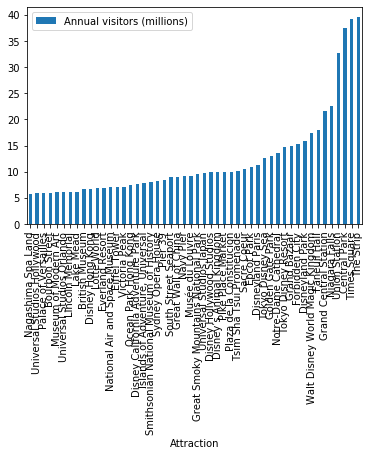

In [180]:
ax = top50.plot.bar(x='Attraction',y='Annual visitors (millions)')
ax

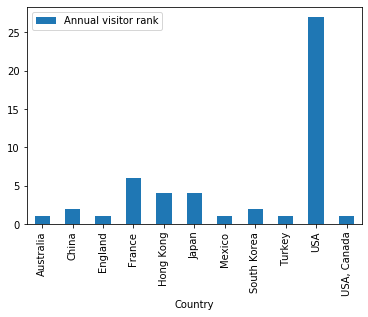

In [177]:
top50_bycountry = top50.groupby('Country').count()
top50_bycountry.reset_index(inplace = True)
ax = top50_bycountry.plot.bar(x='Country',y='Annual visitor rank')
ax


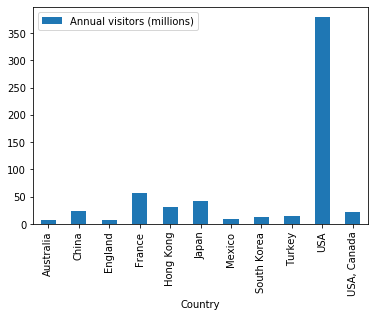

In [178]:
top50_bycountry_sum = top50.groupby('Country').sum()
top50_bycountry_sum.reset_index(inplace = True)
ax = top50_bycountry_sum.plot.bar(x='Country',y='Annual visitors (millions)')

### Geographical data for the locations

In [32]:
# check geodata for first entry
test_latlong = getGeodata(top50.iloc[0]['Attraction']+", "+top50.iloc[0]['City']+", "+top50.iloc[0]['Country'])

In [207]:
map_test = folium.Map(location=test_latlong, zoom_start=11)
label = top50.iloc[0]['Attraction']+', '+str(top50.iloc[0]['Annual visitors (millions)'])+'m annual visitors'
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
    test_latlong,
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_test)  
map_test

In [67]:
# apply getGeodata to top50 dataframe¨
top50['latlong'] = top50.apply(lambda row: getGeodata(row['Attraction']+", "+row['City']+", "+row['Country']), axis=1)

In [79]:
top50.to_csv('top50_latlong.csv',index=False)

In [4]:
# For some lines we did not get a lat/long coordinate. This has been cleaned manually using google maps
# Further, we added a row radius for the subsequent fetching of Forsquare venues. Some attractions are e.g. lakes or mountains, where a radius of e.g. 1000m is too small to fetch any venues.
# We now import the cleaned data again
top50 = pd.read_csv("top50_latlong_final.csv", sep=";")
top50['latlong'] = top50['latlong'].apply(lambda latlong: [float(i) for i in latlong[1:-1].split(",")])

In [5]:
top50.head()

,Annual visitor rank,Attraction,City,Country,Annual visitors (millions),latlong,radius
0,50,Nagashima Spa Land,Kuwana,Japan,5.8,"[35.0296052, 136.7315597]",1000
1,48,Universal Studios Hollywood,Los Angeles,USA,5.9,"[34.13913635, -118.35427718777223]",1000
2,48,Palace of Versailles,Paris,France,5.9,"[48.8048649, 2.1181614]",1000
3,47,Bourbon Street,New Orleans,USA,6.0,"[29.9594334, -90.0649002]",1000
4,45,Museum of Modern Art,New York,USA,6.1,"[40.761612400000004, -73.97749918210806]",1000


In [6]:
#show locations of attractions
map_test = folium.Map(location=top50.iloc[2]['latlong'], zoom_start=2)
for latlong,title in zip(top50['latlong'], top50['Attraction']):
    label = title
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        latlong,
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_test)  
map_test

Now that we have explored the data, it is time to use Forsquare's API to get nearby recommended places

## 3. Get Nearby Recommended Places from Forsquare

In [9]:
top50_nearby_venues = getNearbyVenues(names=top50['Attraction'], countries=top50['Country'],latlong=top50['latlong'],radius=top50['radius'])

Nagashima Spa Land
Universal Studios Hollywood
Palace of Versailles
Bourbon Street
Museum of Modern Art
Universal Studios Orlando
Lincoln Memorial
Lake Mead
British Museum
Disney Hong Kong
Lotte World
Everland Resort
National Air and Space Museum
Eiffel Tower
Victoria Peak
Ocean Park Hong Kong
Disney California Adventure Park
Islands of Adventure, Universal
Smithsonian National Museum of History
Sydney Opera House
Pier 39
South Street Seaport
Great Wall of China
Navy Pier
Musée du Louvre
Great Smoky Mountains National Park
Universal Studios Japan
Disney Hollywood Studios
Disney’s Animal Kingdom
Pike Place Market
Plaza de la Constitución
Tsim Sha Tsui Promenade
Sacre Coeur
Epcot Park
Disneyland Paris
Tokyo Disney Sea
Golden Gate Park
Notre-Dame Cathedral
Tokyo Disney Resort
Grand Bazaar
Forbidden City
Disneyland Park
Walt Disney World Magic Kingdom
Faneuil Hall
Grand Central Station
Niagara Falls
Union Station
Central Park
Times Square
The Strip


In [10]:
top50_nearby_venues.groupby('Attraction Name').count()

,Country,Attraction Latitude,Attraction Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Attraction Name,,,,,,,
Bourbon Street,100,100,100,100,100,100,100
British Museum,100,100,100,100,100,100,100
Central Park,100,100,100,100,100,100,100
Disney California Adventure Park,100,100,100,100,100,100,100
Disney Hong Kong,56,56,56,56,56,56,56
Disneyland Paris,89,89,89,89,89,89,89
Disneyland Park,100,100,100,100,100,100,100
Disney’s Animal Kingdom,41,41,41,41,41,41,41
Eiffel Tower,100,100,100,100,100,100,100


In [133]:
print('There are {} uniques categories.'.format(len(top50_nearby_venues['Venue Category'].unique())))

There are 290 uniques categories.


The high number of unique categories could be an issue. We later probably need to group similar categories into one, e.g. all types of restaurants (there are quite a few, see next line)

In [132]:
top50_nearby_venues[top50_nearby_venues['Venue Category'].str.contains("Restaurant")]['Venue Category'].unique()

array(['Restaurant'], dtype=object)

## Analyzing Attractions

In [150]:
# Cleaning Venues
# more work todo for better results
top50_nearby_venues['Venue Category'].loc[top50_nearby_venues['Venue Category'].str.contains('Restaurant')] = 'Restaurant'

In [134]:
# one hot encoding
top50_onehot = pd.get_dummies(top50_nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add attraction column back to dataframe
top50_onehot['Attraction Name'] = top50_nearby_venues['Attraction Name'] 

# move neighborhood column to the first column
fixed_columns = [top50_onehot.columns[-1]] + list(top50_onehot.columns[:-1])
top50_onehot = top50_onehot[fixed_columns]

top50_onehot.head()

,Attraction Name,Accessories Store,Airport,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,...,Volleyball Court,Water Park,Waterfall,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Nagashima Spa Land,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nagashima Spa Land,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nagashima Spa Land,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Nagashima Spa Land,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Nagashima Spa Land,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by Attraction and by taking the mean of the frequency of occurrence of each category

In [135]:
top50_grouped = top50_onehot.groupby('Attraction Name').mean().reset_index()
top50_grouped.head()

,Attraction Name,Accessories Store,Airport,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,...,Volleyball Court,Water Park,Waterfall,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Bourbon Street,0.02,0.0,0.01,0.0,0.000000,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.02,0.00,0.00,0.0,0.0,0.0
1,British Museum,0.00,0.0,0.00,0.0,0.000000,0.00,0.00,0.02,0.0,...,0.0,0.0,0.0,0.0,0.01,0.00,0.00,0.0,0.0,0.0
2,Central Park,0.00,0.0,0.00,0.0,0.000000,0.01,0.04,0.00,0.0,...,0.0,0.0,0.0,0.0,0.02,0.01,0.01,0.0,0.0,0.0
3,Disney California Adventure Park,0.01,0.0,0.00,0.0,0.000000,0.03,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.03,0.00,0.00,0.0,0.0,0.0
4,Disney Hong Kong,0.00,0.0,0.00,0.0,0.017857,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0


Print each Attraction with top 5 most common venues

In [136]:
num_top_venues = 5

for attraction in top50_grouped['Attraction Name']:
    print("----"+attraction+"----")
    temp = top50_grouped[top50_grouped['Attraction Name'] == attraction].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bourbon Street----
        venue  freq
0  Restaurant  0.20
1   Jazz Club  0.08
2         Bar  0.06
3       Hotel  0.06
4        Park  0.05


----British Museum----
          venue  freq
0    Restaurant  0.14
1       Theater  0.09
2  Cocktail Bar  0.06
3         Hotel  0.06
4   Coffee Shop  0.06


----Central Park----
         venue  freq
0      Exhibit  0.13
1         Park  0.12
2   Restaurant  0.09
3       Garden  0.04
4  Coffee Shop  0.04


----Disney California Adventure Park----
                          venue  freq
0  Theme Park Ride / Attraction  0.34
1                    Theme Park  0.11
2                         Hotel  0.08
3         General Entertainment  0.04
4                     Gift Shop  0.04


----Disney Hong Kong----
                          venue  freq
0  Theme Park Ride / Attraction  0.50
1                     Gift Shop  0.05
2                    Restaurant  0.05
3                          Café  0.04
4                        Buffet  0.04


----Disneyland Paris---

Put result into dataframe

In [159]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Attraction Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
attractions_venues_sorted = pd.DataFrame(columns=columns)
attractions_venues_sorted['Attraction Name'] = top50_grouped['Attraction Name']

for ind in np.arange(top50_grouped.shape[0]):
    attractions_venues_sorted.iloc[ind, 1:] = return_most_common_venues(top50_grouped.iloc[ind, :], num_top_venues)

attractions_venues_sorted.head()

,Attraction Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bourbon Street,Restaurant,Jazz Club,Bar,Hotel,Park,Cocktail Bar,Café,Breakfast Spot,Accessories Store,Coffee Shop
1,British Museum,Restaurant,Theater,Hotel,Cocktail Bar,Coffee Shop,Bookstore,Exhibit,Steakhouse,Bakery,Arts & Crafts Store
2,Central Park,Exhibit,Park,Restaurant,Garden,Playground,Art Museum,Coffee Shop,Bookstore,Theater,Planetarium
3,Disney California Adventure Park,Theme Park Ride / Attraction,Theme Park,Hotel,Gift Shop,General Entertainment,Wine Bar,Art Gallery,Restaurant,Plaza,Candy Store
4,Disney Hong Kong,Theme Park Ride / Attraction,Gift Shop,Restaurant,Hotel,Theater,Buffet,Parade,Café,Theme Park,Souvenir Shop


## Attractions Clustering
k-Means clustering of Attractions

In [160]:
# set number of clusters
kclusters = 5

top50_grouped_clustering = top50_grouped.drop('Attraction Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(top50_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 1, 1, 1, 1, 0, 2, 1])

Create dataframe with cluster and top10 venues

In [161]:
# add clustering labels
attractions_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
attractions_venues_sorted.rename(columns={'Attraction Name':'Attraction'}, inplace=True)
top50_merged = top50

# merge top50_grouped with top50_data to add latitude/longitude for each attraction
top50_merged = top50_merged.join(attractions_venues_sorted.set_index('Attraction'), on='Attraction')

top50_merged.head() # check the last columns!

,Annual visitor rank,Attraction,City,Country,Annual visitors (millions),latlong,radius,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,50,Nagashima Spa Land,Kuwana,Japan,5.8,"[35.0296052, 136.7315597]",1000,1.0,Theme Park Ride / Attraction,Boutique,Clothing Store,Restaurant,Hotel,Outdoor Supply Store,Food Court,Hot Spring,Ice Cream Shop,Sporting Goods Shop
1,48,Universal Studios Hollywood,Los Angeles,USA,5.9,"[34.13913635, -118.35427718777223]",1000,1.0,Restaurant,Theme Park,Theme Park Ride / Attraction,Coffee Shop,Hotel,Diner,Bar,Burger Joint,Souvenir Shop,Movie Theater
2,48,Palace of Versailles,Paris,France,5.9,"[48.8048649, 2.1181614]",1000,2.0,Restaurant,Historic Site,Sculpture Garden,Creperie,Fountain,Café,Garden,Hotel,Bakery,Botanical Garden
3,47,Bourbon Street,New Orleans,USA,6.0,"[29.9594334, -90.0649002]",1000,0.0,Restaurant,Jazz Club,Bar,Hotel,Park,Cocktail Bar,Café,Breakfast Spot,Accessories Store,Coffee Shop
4,45,Museum of Modern Art,New York,USA,6.1,"[40.761612400000004, -73.97749918210806]",1000,0.0,Restaurant,Hotel,Theater,Jewelry Store,Concert Hall,Plaza,Spa,Gym,Park,Food & Drink Shop


In [163]:
top50_merged['Cluster Labels'].unique()

array([1., 2., 0., 4., 3.])

In [162]:
#drop non-classified attractions
top50_merged.dropna(inplace=True)

Visualization

In [164]:
# create map
map_clusters = folium.Map(location=top50.iloc[2]['latlong'], zoom_start=3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for latlong, poi, cluster in zip(top50_merged['latlong'], top50_merged['Attraction'], top50_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        latlong,
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [165]:
top50_merged.loc[top50_merged['Cluster Labels'] == 0, top50_merged.columns[[1] + list(range(5, top50_merged.shape[1]))]]

,Attraction,latlong,radius,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bourbon Street,"[29.9594334, -90.0649002]",1000,0.0,Restaurant,Jazz Club,Bar,Hotel,Park,Cocktail Bar,Café,Breakfast Spot,Accessories Store,Coffee Shop
4,Museum of Modern Art,"[40.761612400000004, -73.97749918210806]",1000,0.0,Restaurant,Hotel,Theater,Jewelry Store,Concert Hall,Plaza,Spa,Gym,Park,Food & Drink Shop
6,Lincoln Memorial,"[38.8893233, -77.0501211422511]",1000,0.0,Monument / Landmark,Sandwich Place,Performing Arts Venue,Concert Hall,Bike Rental / Bike Share,Sculpture Garden,Baseball Field,Outdoor Sculpture,Theater,Hotel
8,British Museum,"[51.51929365, -0.12801772178494725]",1000,0.0,Restaurant,Theater,Hotel,Cocktail Bar,Coffee Shop,Bookstore,Exhibit,Steakhouse,Bakery,Arts & Crafts Store
12,National Air and Space Museum,"[38.88813505, -77.0194987456374]",1000,0.0,Restaurant,Science Museum,Exhibit,Art Museum,History Museum,Food Truck,Monument / Landmark,Museum,Art Gallery,Garden
18,Smithsonian National Museum of History,"[38.8912727, -77.0302522]",1000,0.0,Restaurant,History Museum,Art Museum,Science Museum,Hotel,Theater,Exhibit,Garden,Coffee Shop,Monument / Landmark
19,Sydney Opera House,"[-33.85719805, 151.21512338473752]",1000,0.0,Restaurant,Café,Scenic Lookout,Hotel,Theater,Hotel Bar,Cocktail Bar,Park,Pub,Opera House
20,Pier 39,"[37.8097854, -122.4102658]",1000,0.0,Restaurant,Ice Cream Shop,Coffee Shop,Bakery,Tour Provider,Café,Pizza Place,Park,Cosmetics Shop,Donut Shop
23,Navy Pier,"[41.89179985, -87.60414466382959]",1000,0.0,Restaurant,Boat or Ferry,Harbor / Marina,Theme Park Ride / Attraction,Park,Theater,Breakfast Spot,Ice Cream Shop,Snack Place,Burger Joint
28,Disney’s Animal Kingdom,"[28.3560835, -81.6061923]",1000,0.0,Restaurant,Resort,Hotel Bar,Arcade,Gift Shop,Bus Stop,Gym,Café,Toll Plaza,Food Court


In [166]:
top50_merged.loc[top50_merged['Cluster Labels'] == 1, top50_merged.columns[[1] + list(range(5, top50_merged.shape[1]))]]

,Attraction,latlong,radius,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Nagashima Spa Land,"[35.0296052, 136.7315597]",1000,1.0,Theme Park Ride / Attraction,Boutique,Clothing Store,Restaurant,Hotel,Outdoor Supply Store,Food Court,Hot Spring,Ice Cream Shop,Sporting Goods Shop
1,Universal Studios Hollywood,"[34.13913635, -118.35427718777223]",1000,1.0,Restaurant,Theme Park,Theme Park Ride / Attraction,Coffee Shop,Hotel,Diner,Bar,Burger Joint,Souvenir Shop,Movie Theater
5,Universal Studios Orlando,"[28.4711958, -81.4813685]",1000,1.0,Theme Park Ride / Attraction,Theme Park,Gift Shop,Restaurant,Performing Arts Venue,Fountain,Gym / Fitness Center,Golf Course,Bowling Alley,Gas Station
9,Disney Hong Kong,"[22.313077200000002, 114.04097928858846]",1000,1.0,Theme Park Ride / Attraction,Gift Shop,Restaurant,Hotel,Theater,Buffet,Parade,Café,Theme Park,Souvenir Shop
11,Everland Resort,"[37.2936929, 127.1989925]",1000,1.0,Theme Park Ride / Attraction,Restaurant,Garden,Theme Park,Zoo,Water Park,Exhibit,Café,Performing Arts Venue,Lounge
15,Ocean Park Hong Kong,"[22.234971950000002, 114.17073378481506]",1000,1.0,Theme Park Ride / Attraction,Restaurant,Aquarium,Café,Theme Park,Zoo Exhibit,Mountain,Metro Station,Performing Arts Venue,Exhibit
16,Disney California Adventure Park,"[33.8063981, -117.91994985859614]",1000,1.0,Theme Park Ride / Attraction,Theme Park,Hotel,Gift Shop,General Entertainment,Wine Bar,Art Gallery,Restaurant,Plaza,Candy Store
17,"Islands of Adventure, Universal","[28.471878949999997, -81.47121064527349]",1000,1.0,Theme Park Ride / Attraction,Theme Park,Gift Shop,Restaurant,Food Stand,Hotel,Performing Arts Venue,Music Venue,Resort,Playground
26,Universal Studios Japan,"[34.66620035, 135.43244659642798]",1000,1.0,Theme Park Ride / Attraction,Restaurant,Gift Shop,Intersection,Theme Park,Hotel,Convenience Store,Café,Harbor / Marina,Pizza Place
33,Epcot Park,"[28.374694, -81.551598]",1000,1.0,Theme Park Ride / Attraction,Gift Shop,Restaurant,Ice Cream Shop,Souvenir Shop,Wine Shop,Food Stand,Resort,Lounge,Bakery


In [167]:
top50_merged.loc[top50_merged['Cluster Labels'] == 2, top50_merged.columns[[1] + list(range(5, top50_merged.shape[1]))]]

,Attraction,latlong,radius,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Palace of Versailles,"[48.8048649, 2.1181614]",1000,2.0,Restaurant,Historic Site,Sculpture Garden,Creperie,Fountain,Café,Garden,Hotel,Bakery,Botanical Garden
10,Lotte World,"[37.51109475, 127.09824593037186]",1000,2.0,Restaurant,Coffee Shop,Theme Park Ride / Attraction,Café,Bakery,Theme Park,Multiplex,Department Store,Hotel,Scenic Lookout
13,Eiffel Tower,"[48.858260200000004, 2.2944990543196795]",1000,2.0,Restaurant,Hotel,Art Museum,Museum,Bistro,Plaza,Garden,Bakery,Tea Room,Burger Joint
14,Victoria Peak,"[22.2760386, 114.1454573]",1000,2.0,Restaurant,Coffee Shop,Café,Scenic Lookout,Garden,Trail,Dessert Shop,Historic Site,Bakery,Ice Cream Shop
21,South Street Seaport,"[40.7057752, -74.0028376]",1000,2.0,Restaurant,Coffee Shop,Park,Pizza Place,Café,Sandwich Place,Salad Place,Hotel,Bar,Ice Cream Shop
24,Musée du Louvre,"[48.8611473, 2.33802768704666]",1000,2.0,Restaurant,Plaza,Hotel,Wine Bar,Historic Site,Art Museum,Coffee Shop,Cheese Shop,Spa,Art Gallery
29,Pike Place Market,"[47.60939675, -122.34141017673986]",1000,2.0,Restaurant,Hotel,Coffee Shop,Bakery,Pizza Place,Cocktail Bar,Marijuana Dispensary,Grocery Store,Theater,Theme Park Ride / Attraction
31,Tsim Sha Tsui Promenade,"[22.2994457, 114.1851628]",1000,2.0,Restaurant,Hotel,Coffee Shop,Café,Dessert Shop,Buffet,Hotel Bar,Cha Chaan Teng,Snack Place,Food Court
32,Sacre Coeur,"[48.88680575, 2.3430153448835087]",1000,2.0,Restaurant,Bakery,Bar,Plaza,Bistro,Pizza Place,Wine Bar,Hotel,Beer Store,Chocolate Shop
36,Golden Gate Park,"[37.769368099999994, -122.48218371117709]",1000,2.0,Restaurant,Park,Bubble Tea Shop,Bakery,Garden,Deli / Bodega,Grocery Store,Liquor Store,Coffee Shop,Lake


In [168]:
top50_merged.loc[top50_merged['Cluster Labels'] == 3, top50_merged.columns[[1] + list(range(5, top50_merged.shape[1]))]]

,Attraction,latlong,radius,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Great Smoky Mountains National Park,"[35.5797831, -84.0930678]",5000,3.0,Nightlife Spot,Leather Goods Store,Harbor / Marina,Motorcycle Shop,Mountain,Moving Target,Food Truck,Restaurant,BBQ Joint,Resort


In [169]:
top50_merged.loc[top50_merged['Cluster Labels'] == 4, top50_merged.columns[[1] + list(range(5, top50_merged.shape[1]))]]

,Attraction,latlong,radius,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Great Wall of China,"[40.3555116, 116.0085921]",1000,4.0,Historic Site,Mountain,Nature Preserve,Bus Station,Bus Stop,Cable Car,Restaurant,Sandwich Place,Food Truck,Food & Drink Shop
40,Forbidden City,"[39.91727565, 116.39076940577283]",1000,4.0,Historic Site,Restaurant,Hotel,Café,Park,Hostel,Scenic Lookout,Sandwich Place,Garden,Food Court
